# 0. 기본 라이브러리, 함수 Import

In [1]:
!pip install tensorboardX

In [0]:
import torch
import torch.nn as nn
from torch import autograd, optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import random

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

writer = SummaryWriter(logdir='runs/GAN_training')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img_numpy = img.numpy()
    print(img_numpy.shape)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
    plt.show()

# __GAN 훈련에 대한 부분__

# 1. Model Architecture

## 1-1. Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, img_shape, latent_dim):
        super().__init__()
        self.img_shape = img_shape

        def block(in_feature, out_feature, normalize=True):
            layers = [nn.Linear(in_feature, out_feature)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feature, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, input):
        img = self.model(input)
        
        return img.view(img.shape[0], *self.img_shape)

## 1-2. Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.last_layer = nn.Sequential(
            nn.Linear(128, 1)
        )

    def forward_features(self, img):
        img_flat = img.view(img.shape[0], -1) # 이미지가 들어올 때 Linear에 들어가기 위해 shape을 Flatten 해줌.
        features = self.features(img_flat)
        return features

    def forward(self, img):
        features = self.forward_features(img)
        validity = self.last_layer(features)
        return validity


## 1-3. Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, img_shape, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, latent_dim),
            nn.Tanh()
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

# 2. Hyper Parameters 정의

In [0]:
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 100
img_size = 28
channels = 1
n_critic = 5
sample_interval = 400
training_label = 0
split_rate = 0.8
lambda_gp = 10

# 3. Data 읽어오기.

## 3-1. Custom Data Class 정의

In [0]:
class SimpleDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.transform = transform
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        labels = self.labels[idx]

        if self.transform:
            data = self.transform(data)

        return data, labels

## 3-2. Train Data, Data Loader 정의

In [0]:
# Train Data
train_dataset = MNIST('./', train=True, download=True)

_x_train = train_dataset.data[train_dataset.targets == 1]
x_train, x_test_normal = _x_train.split((int(len(_x_train) * split_rate)), dim=0)

_y_train = train_dataset.targets[train_dataset.targets == 1]
y_train, y_test_normal = _y_train.split((int(len(_y_train) * split_rate)), dim=0)

train_mnist = SimpleDataset(x_train, y_train,
                                transform=transforms.Compose(
                                    [transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5])])
                                )
train_dataloader = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)

# 4. GAN 학습

In [0]:
img_shape = (channels, img_size, img_size) # (1, 28, 28)

G = Generator(img_shape, latent_dim).to(device)
D = Discriminator(img_shape).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, weight_decay=1e-5)
optimizer_D = optim.Adam(D.parameters(), lr=lr, weight_decay=1e-5)

## 4-1. WGGAN-GP loss

In [0]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(*real_samples.shape[:2], 1, 1).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples)
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    d_interpolates = D(interpolates)
    fake = torch.ones(*d_interpolates.shape).to(device)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(outputs=d_interpolates, inputs=interpolates,
                              grad_outputs=fake, create_graph=True,
                              retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## 4-2. GAN training

### 4-2-1. Tensor Board

In [12]:
%load_ext tensorboard
%tensorboard --logdir runs --port=6008

<IPython.core.display.Javascript object>

### 4-2-2. Training

In [13]:
padding_epoch = len(str(n_epochs)) #3
padding_i = len(str(len(train_dataloader))) # 2

d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        z = torch.randn(imgs.shape[0], latent_dim).to(device) # 64, 100

        fake_imgs = G(z)

        real_validity = D(real_imgs)
        fake_validity = D(fake_imgs.detach())

        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(D, real_imgs.data, fake_imgs.data)
        
        # Adversarial loss
        d_loss = (-torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty)
        d_loss.backward()
        
        optimizer_D.step()
        
        if i % n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            
            fake_imgs = G(z)
            fake_validity = D(fake_imgs)

            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            writer.add_scalars('GAN loss', {'G_loss': g_loss.item(), 'D_loss': d_loss.item()}, epoch)
            
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                f"[D loss: {d_loss.item():3f}] "
                f"[G loss: {g_loss.item():3f}]")
# writer.close()
print('Finished Training')


[Epoch   0/200] [Batch  0/85] [D loss: 9.648405] [G loss: -0.016270]
[Epoch   0/200] [Batch  5/85] [D loss: 7.377916] [G loss: -0.016616]
[Epoch   0/200] [Batch 10/85] [D loss: 0.027496] [G loss: -0.033117]
[Epoch   0/200] [Batch 15/85] [D loss: -17.270271] [G loss: -0.131594]
[Epoch   0/200] [Batch 20/85] [D loss: -37.676498] [G loss: -0.457772]
[Epoch   0/200] [Batch 25/85] [D loss: -32.947861] [G loss: -0.725256]
[Epoch   0/200] [Batch 30/85] [D loss: -40.165855] [G loss: -0.667597]
[Epoch   0/200] [Batch 35/85] [D loss: -39.482830] [G loss: -0.695257]
[Epoch   0/200] [Batch 40/85] [D loss: -40.474636] [G loss: -0.967191]
[Epoch   0/200] [Batch 45/85] [D loss: -40.199516] [G loss: -1.292460]
[Epoch   0/200] [Batch 50/85] [D loss: -40.364166] [G loss: -1.480447]
[Epoch   0/200] [Batch 55/85] [D loss: -40.309471] [G loss: -1.571552]
[Epoch   0/200] [Batch 60/85] [D loss: -40.433041] [G loss: -1.796083]
[Epoch   0/200] [Batch 65/85] [D loss: -40.174431] [G loss: -2.198942]
[Epoch   0/2

### 4-2-3. matplotlib를 이용해서 loss 그려보기.

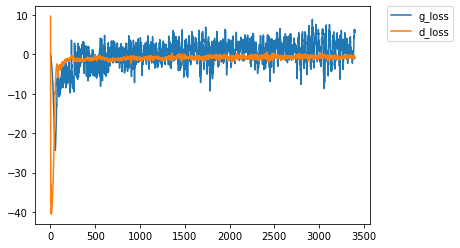

In [14]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 4-2-4. Normal Fake Image 출력해보기.


(3, 242, 242)


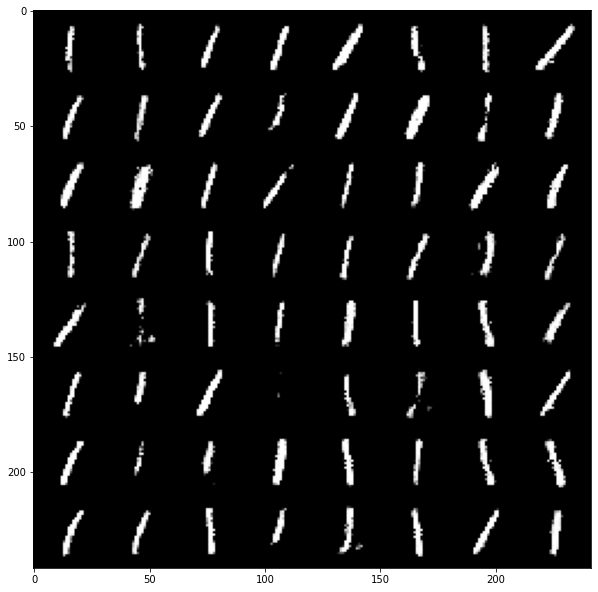

In [15]:
z = torch.randn(64, latent_dim).to(device)
imshow_grid(G(z))

# 5. Encoder izif 훈련

In [16]:
writer = SummaryWriter(logdir='runs/Encoder_training')
img_shape = (channels, img_size, img_size)

E = Encoder(img_shape, latent_dim).to(device)
G.eval()
D.eval()

criterion = nn.MSELoss()

optimizer_E = torch.optim.Adam(E.parameters(), lr=lr, betas=(b1, b2))

padding_epoch = len(str(n_epochs))
padding_i = len(str(len(train_dataloader)))
kappa = 1.0
e_losses = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)
        
        optimizer_E.zero_grad() 
        z = E(real_imgs) # 64, 100
        
        fake_imgs = G(z)

        real_features = D.forward_features(real_imgs)
        fake_features = D.forward_features(fake_imgs)
        # real_feature = real_features / real_features.max()
        # fake_features = fake_features / fake_features.max()

        # izif architecture
        loss_imgs = criterion(fake_imgs, real_imgs)
        loss_features = criterion(fake_features, real_features)
        e_loss = loss_imgs + kappa * loss_features

        e_loss.backward()
        optimizer_E.step()


        if i % n_critic == 0:
            e_losses.append(e_loss)

            writer.add_scalar('e_loss', e_loss.item(), epoch)
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                    f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                    f"[E loss: {e_loss.item():3f}]")
            
#writer.close()
print('Finished Training')

[Epoch   0/200] [Batch  0/85] [E loss: 2.414365]
[Epoch   0/200] [Batch  5/85] [E loss: 2.041958]
[Epoch   0/200] [Batch 10/85] [E loss: 0.764229]
[Epoch   0/200] [Batch 15/85] [E loss: 0.581474]
[Epoch   0/200] [Batch 20/85] [E loss: 0.534910]
[Epoch   0/200] [Batch 25/85] [E loss: 0.464178]
[Epoch   0/200] [Batch 30/85] [E loss: 0.466521]
[Epoch   0/200] [Batch 35/85] [E loss: 0.796552]
[Epoch   0/200] [Batch 40/85] [E loss: 0.403280]
[Epoch   0/200] [Batch 45/85] [E loss: 0.433394]
[Epoch   0/200] [Batch 50/85] [E loss: 0.451505]
[Epoch   0/200] [Batch 55/85] [E loss: 0.419426]
[Epoch   0/200] [Batch 60/85] [E loss: 0.358828]
[Epoch   0/200] [Batch 65/85] [E loss: 0.332232]
[Epoch   0/200] [Batch 70/85] [E loss: 0.383925]
[Epoch   0/200] [Batch 75/85] [E loss: 0.417880]
[Epoch   0/200] [Batch 80/85] [E loss: 0.343176]
[Epoch   1/200] [Batch  0/85] [E loss: 0.367020]
[Epoch   1/200] [Batch  5/85] [E loss: 0.380528]
[Epoch   1/200] [Batch 10/85] [E loss: 0.312700]
[Epoch   1/200] [Bat

## 5-1. Encoder를 이용한 mapping된 latent vector를 이용해서 fake image 확인


(3, 242, 242)


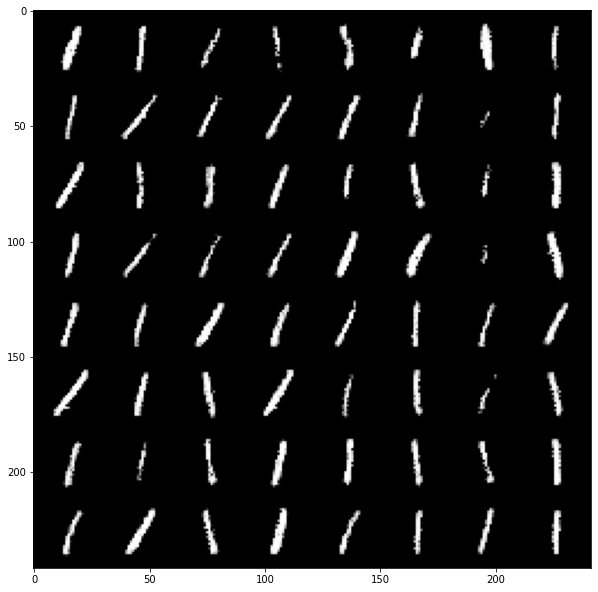

In [17]:
z = torch.randn(64, latent_dim).to(device) # 64, 100
fake_imgs = G(z) # 64, 1, 28, 28
fake_z = E(fake_imgs) #64, 100
reconfiguration_imgs = G(fake_z)

imshow_grid(reconfiguration_imgs)

# 6. 최종 결과 확인


## 6-1. Test Data load

- normal data : 1
- abnormal data : 1을 제외한 나머지 숫자 값

In [0]:
# Test DAta
test_dataset = MNIST('./', train=False, download=False)

#x_test = torch.cat([x_test_normal[:10], train_dataset.data[train_dataset.targets != 1], test_dataset.data], dim=0)[:20]
#y_test = torch.cat([y_test_normal[:10], train_dataset.targets[train_dataset.targets != 1], test_dataset.targets], dim=0)[:20]
x_test = torch.cat([x_test_normal, train_dataset.data[train_dataset.targets != 1], test_dataset.data], dim=0)
y_test = torch.cat([y_test_normal, train_dataset.targets[train_dataset.targets != 1], test_dataset.targets], dim=0)

test_mnist = SimpleDataset(x_test, y_test,
                            transform=transforms.Compose(
                            [transforms.ToPILImage(),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5])])
                            )

test_dataloader = DataLoader(test_mnist, batch_size=1, shuffle=True)

In [0]:
def compare_images(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(28, 28) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(28, 28) * 255

    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    
    diff_img[diff_img <= threshold] = 0

    anomaly_img = np.zeros(shape=(28, 28, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    fig, plots = plt.subplots(1, 4)
    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label='real')
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

0, 0.5459722876548767, 0.547654926776886, 0.17541339993476868



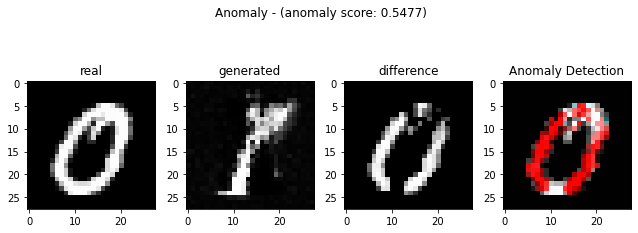

4, 0.39292198419570923, 0.3936542272567749, 0.06921856105327606



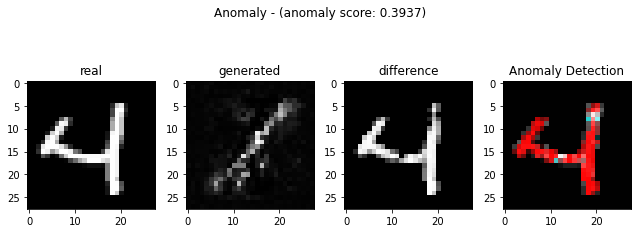

2, 0.30295267701148987, 0.3032543659210205, 0.02360207960009575



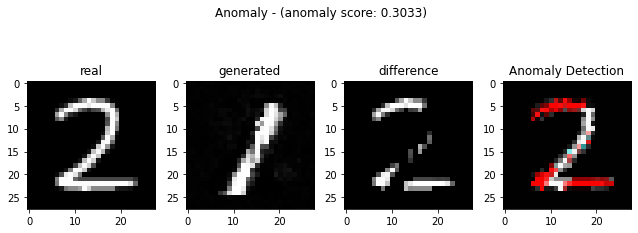

7, 0.14311891794204712, 0.14331062138080597, 0.018669702112674713



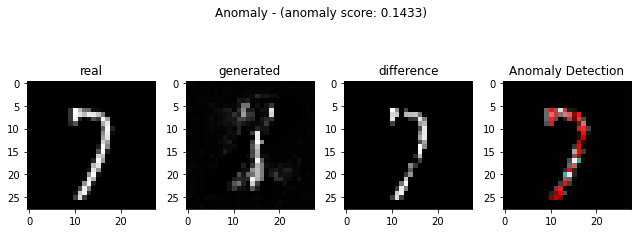

4, 0.3201359212398529, 0.3207176625728607, 0.07838989049196243



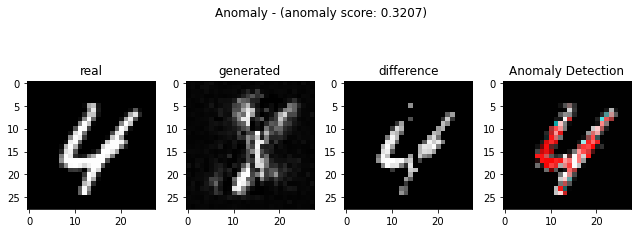

2, 0.42591503262519836, 0.42709872126579285, 0.05108487978577614



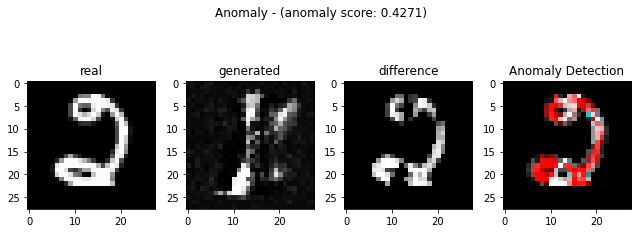

9, 0.35050004720687866, 0.35073259472846985, 0.09951255470514297



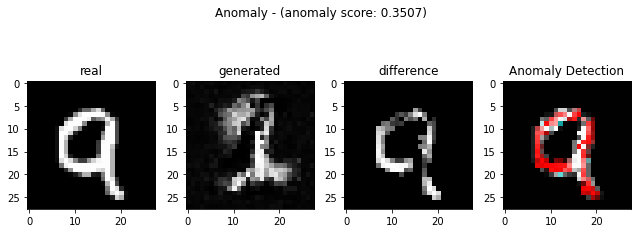

6, 0.6083859801292419, 0.6099404096603394, 0.08875782787799835



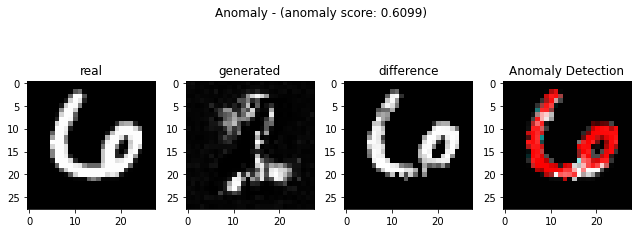

4, 0.28752991557121277, 0.2883308529853821, 0.10812555998563766



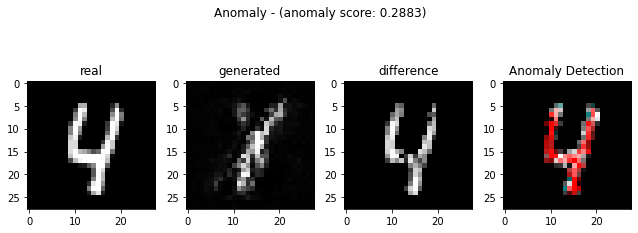

6, 0.36431771516799927, 0.36498111486434937, 0.08705756068229675



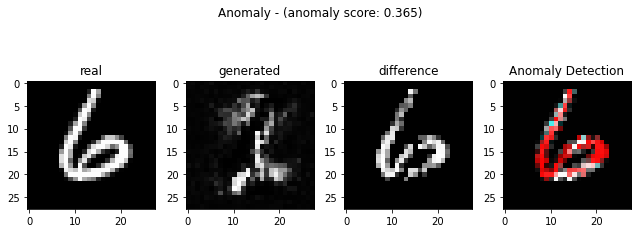

1, 0.021321546286344528, 0.021424759179353714, 0.0011662053875625134



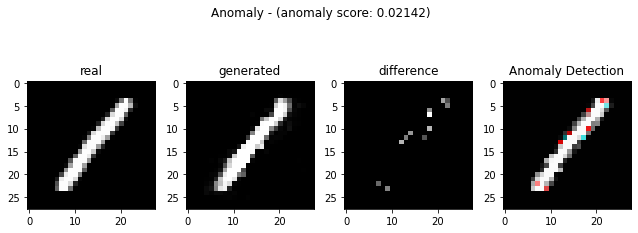

9, 0.39499297738075256, 0.39673036336898804, 0.05493583530187607



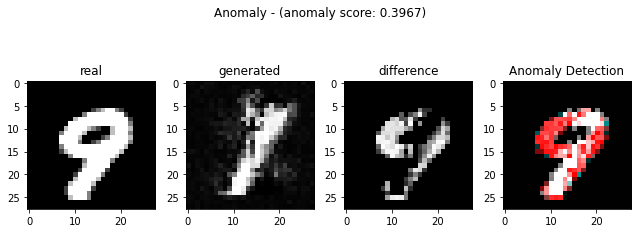

0, 0.5220004916191101, 0.5228649377822876, 0.06896834075450897



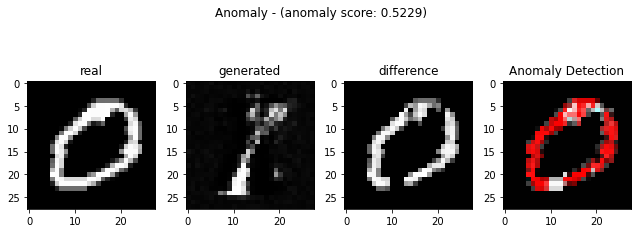

5, 0.16929380595684052, 0.1708114892244339, 0.03851938992738724



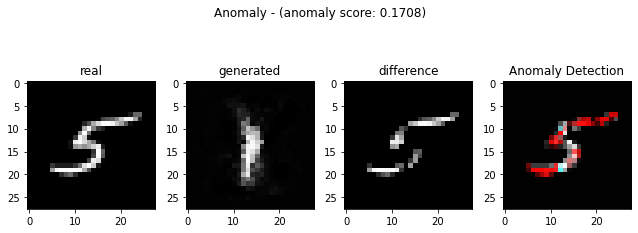

4, 0.3608843982219696, 0.36708736419677734, 0.07225874811410904



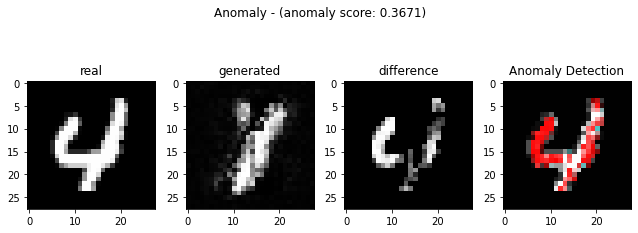

9, 0.48515334725379944, 0.48579999804496765, 0.06821241229772568



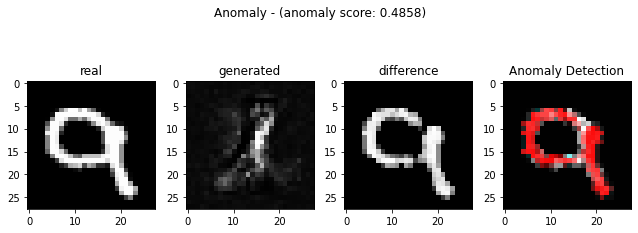

9, 0.2560100555419922, 0.25635015964508057, 0.036505281925201416



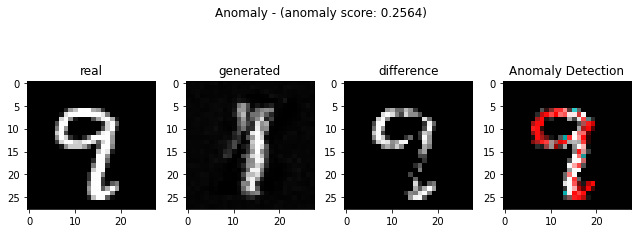

4, 0.40939274430274963, 0.4098540246486664, 0.16475370526313782



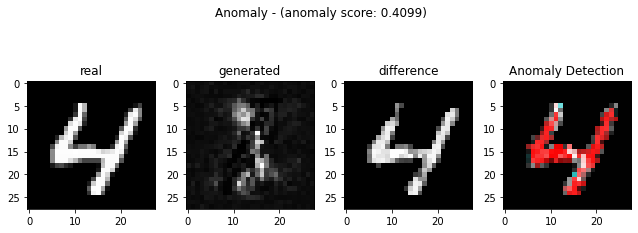

7, 0.2587471604347229, 0.2589103877544403, 0.022903677076101303



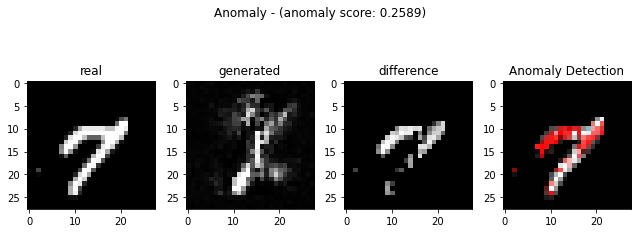

3, 0.2028835266828537, 0.20320762693881989, 0.04203234985470772



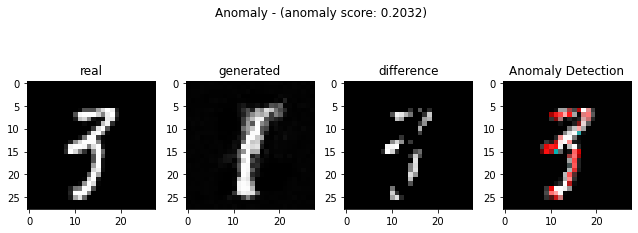

5, 0.3835475742816925, 0.3843206763267517, 0.05133816972374916



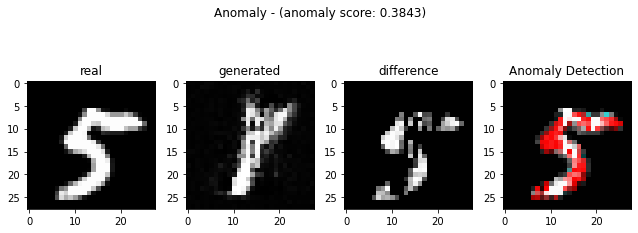

0, 0.5039309859275818, 0.5045945048332214, 0.060667891055345535



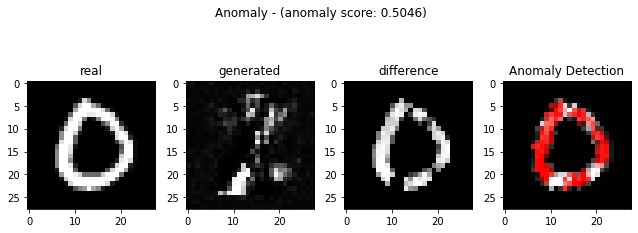

6, 0.392742395401001, 0.3936421871185303, 0.026929883286356926



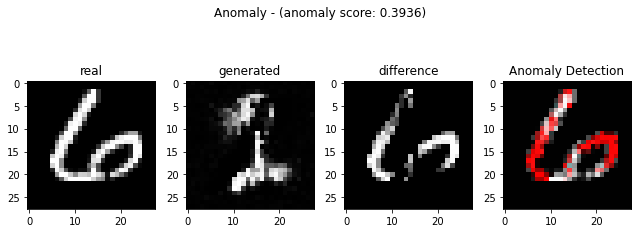

0, 0.47963786125183105, 0.48026570677757263, 0.030331015586853027



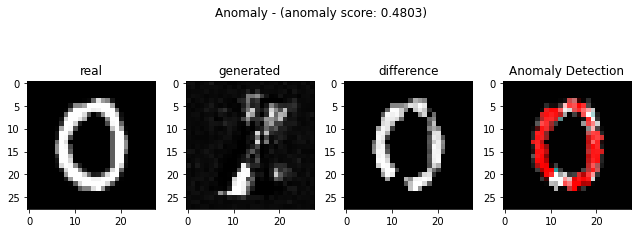

4, 0.37072932720184326, 0.3715626895427704, 0.11163613945245743



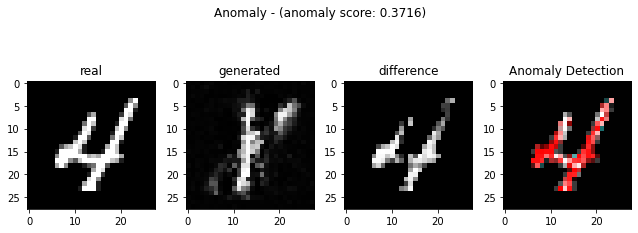

0, 0.4209890067577362, 0.4214276671409607, 0.07609035074710846



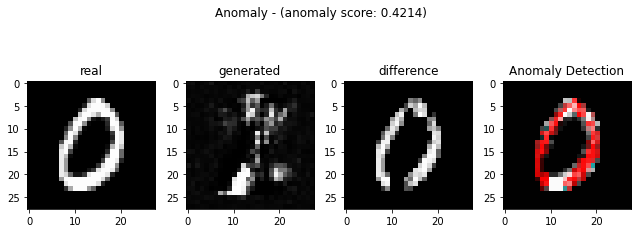

9, 0.3630352318286896, 0.36370521783828735, 0.06135554239153862



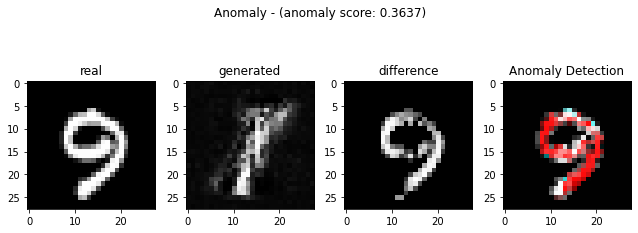

3, 0.2910880446434021, 0.2918832302093506, 0.05091428756713867



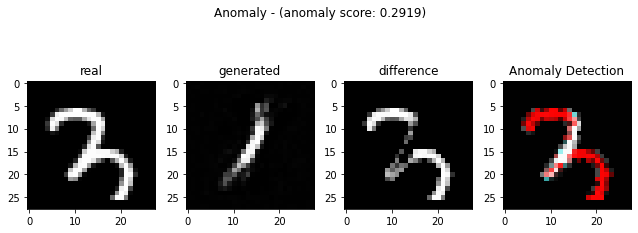

6, 0.342460572719574, 0.34554892778396606, 0.04678191989660263



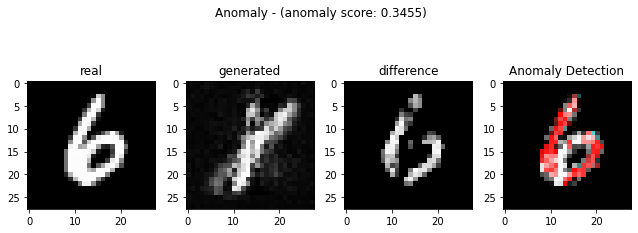

0, 0.5463489294052124, 0.5472649931907654, 0.08079266548156738



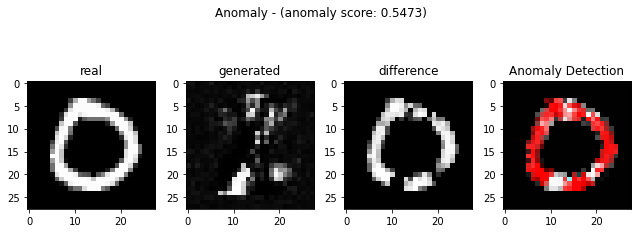

4, 0.3740611970424652, 0.37559279799461365, 0.1420140564441681



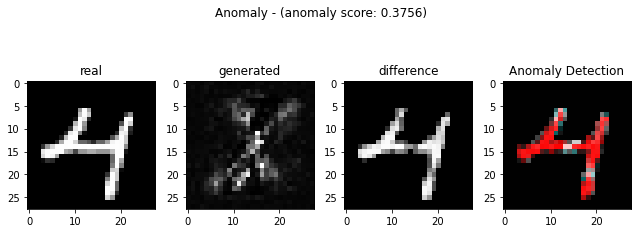

4, 0.337640643119812, 0.3382088541984558, 0.07796578854322433



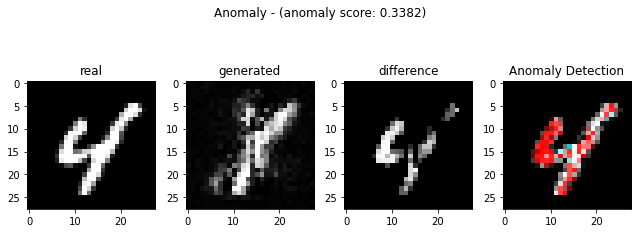

5, 0.3002627193927765, 0.300875186920166, 0.032029926776885986



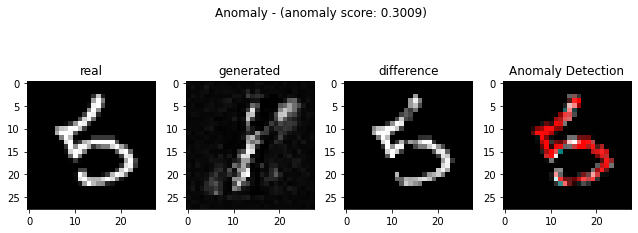

In [20]:
img_shape = (channels, img_size, img_size)

criterion = nn.MSELoss()
G.eval()
D.eval()
E.eval()

with open("score.csv", "w") as f:
        f.write("label,img_distance,anomaly_score,z_distance\n")

for i, (img, label) in enumerate(test_dataloader):
    real_img = img.to(device)

    real_z = E(real_img) # 진짜 이미지의 latent vector
    fake_img = G(real_z) # G에 넣어서 가짜 이미지 생성.
    fake_z = E(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    real_feature = D.forward_features(real_img) # 1, 256
    fake_feature = D.forward_features(fake_img)
    real_feature = real_feature / real_feature.max()
    fake_feature = fake_feature / fake_feature.max()
    # print("real_feature max : ",real_feature.max())
    # print("real_feature min : ",real_feature.min())
    # print("fake_feature max : ",fake_feature.max())
    # print("fake_feature min : ",fake_feature.min())

    img_distance = criterion(fake_img, real_img)
    loss_feature = criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = criterion(fake_z, real_z)
    
    with open("score.csv", "a") as f:
            f.write(f"{label.item()},{img_distance},"
                    f"{anomaly_score},{z_distance}\n")
    
    if i % 2000 == 0:
        print(f"{label.item()}, {img_distance}, "
          f"{anomaly_score}, {z_distance}\n")
        compare_images(real_img, fake_img,i, anomaly_score, reverse = False, threshold = 80)



# 7. Visualization

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [22]:
df = pd.read_csv("score.csv")
df

label  img_distance  anomaly_score  z_distance
0          0      0.545972       0.547655    0.175413
1          3      0.290915       0.291229    0.031473
2          6      0.475183       0.475709    0.092465
3          9      0.166079       0.166260    0.035729
4          6      0.564313       0.566344    0.092393
...      ...           ...            ...         ...
64602      0      0.499940       0.505140    0.067012
64603      3      0.358095       0.358660    0.159028
64604      0      0.306037       0.306894    0.030310
64605      2      0.480893       0.481632    0.089359
64606      2      0.182140       0.182565    0.108761

[64607 rows x 4 columns]

In [0]:
trainig_label = 1
labels = np.where(df["label"].values == trainig_label, 0, 1)
anomaly_score = df["anomaly_score"].values
img_distance = df["img_distance"].values
z_distance = df["z_distance"].values

In [0]:
fpr, tpr, _ = roc_curve(labels, img_distance)
precision, recall, _ = precision_recall_curve(labels, img_distance)
roc_auc = auc(fpr, tpr)
pr_auc =  auc(recall, precision)

## 7-1. Image-level anomaly detection accuracy evaluation

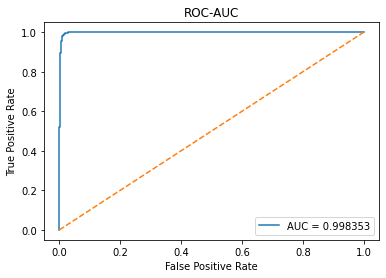

In [25]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

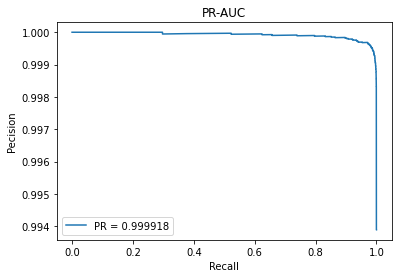

In [26]:
plt.plot(recall, precision, label=f"PR = {pr_auc:3f}")
plt.title("PR-AUC")
plt.xlabel("Recall")
plt.ylabel("Pecision")
plt.legend()
plt.show()

## 7-2. Discrete distributions of anomaly scores

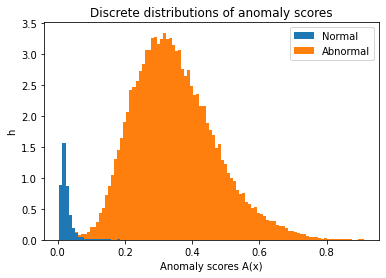

In [27]:
plt.hist([anomaly_score[labels == 0], anomaly_score[labels == 1]],
          bins=100, density=True, stacked=True,
          label=["Normal", "Abnormal"])
plt.title("Discrete distributions of anomaly scores")
plt.xlabel("Anomaly scores A(x)")
plt.ylabel("h")
plt.legend()
plt.show()